## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os, cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models              
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision.io import read_video
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score


## Display few images from dataset

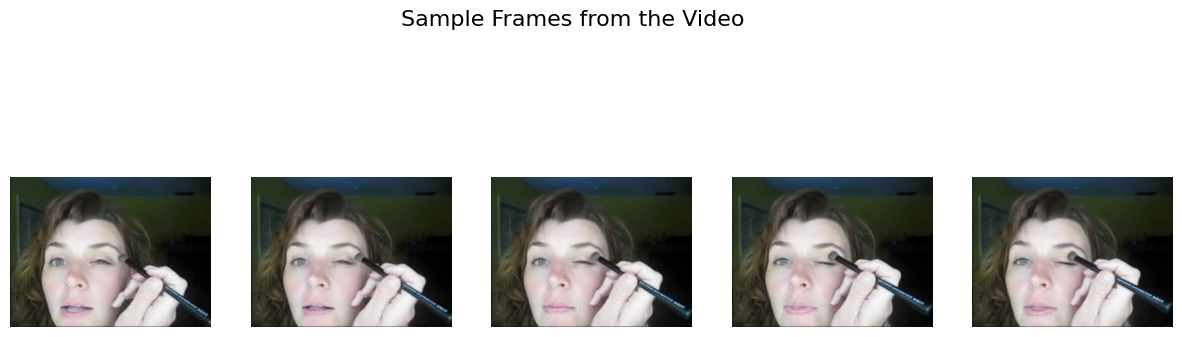

In [2]:
video_path = "/kaggle/input/ucf101-action-recognition/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g06_c01.avi"
cap = cv2.VideoCapture(video_path)

frames = []
for i in range(10):  # read first 10 frames
    ret, frame = cap.read()

    # “If the video can’t provide another frame,
    # stop reading immediately — don’t continue the loop.”
    if not ret:
        break

    # OpenCV reads images in BGR format (Blue-Green-Red),
    # but Matplotlib expects RGB (Red-Green-Blue).
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

# tells cv: “I’m done using the video file — free up the system resources.”
# If you don’t release it, sometimes the file remains locked.
cap.release()

# Display first 5 frames
plt.figure(figsize=(15, 5))
for i in range(min(5, len(frames))):
    plt.subplot(1, 5, i+1)
    plt.imshow(frames[i])
    plt.axis('off')
plt.suptitle("Sample Frames from the Video", fontsize=16)
plt.show()


## cheking device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Set seed for reproducibility:

In [4]:
import random

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False
seed_everything(42)


## Paths

In [5]:
train_root = "/kaggle/input/ucf101-action-recognition/train" # train folder
val_root   = "/kaggle/input/ucf101-action-recognition/test"  # or val folder

## Custom Dataset Loader (For folder-based Dataset)

In [6]:
# ImageNet normalisation (for pretrained ResNet)
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

def sample_frame_indices(total_frames, num_frames):
    if total_frames <= num_frames:
        # return all frames indices (will pad later)
        return list(range(total_frames))
     # uniform sampling
    return np.linspace(0, total_frames - 1, num_frames).astype(int).tolist()


class VideoFolderDataset(Dataset):
    """
    Expects folder structure: root/class_name/*.avi
    Returns: frames tensor (num_frames, C, H, W), label (int)
    """

    def __init__(self, root_dir, num_frames, transform=None, ext=('.avi','.mp4')):
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.transform = transform
        self.ext = ext

         # build list
        classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.classes = classes
        self.class_to_idx = {c:i for i,c in enumerate(classes)}

        # samples is a list of tuple, containing path of video and label
        self.samples = []
        for c in classes:
            cdir = os.path.join(root_dir, c)
            for fname in os.listdir(cdir):
                self.samples.append((os.path.join(cdir, fname), self.class_to_idx[c]))

        if len(self.samples) == 0:
            raise RuntimeError(f"No videos found in {root_dir}")
    

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        frames = self._read_video(path)

        # frames is list of HxWxC uint8
        if self.transform is not None:
            frames = [self.transform(frame) for frame in frames]
             # stack -> (num_frames, C, H, W)
            frames = torch.stack(frames)
            return frames, label

    # 👉 _read_video()
    # is responsible for turning a raw video file (.avi, .mp4) into a clean, 
    # consistent set of frames that can be fed into your deep learning model.

    def _read_video(self, path):
        cap = cv2.VideoCapture(path)
        # total num of frames
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0

        # fallback attempt: read until EOF
        if total == 0:
            frames = []
            
            while True:    
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            cap.release()
            total = len(frames)
        else:
            frames = None

        idxs = sample_frame_indices(total or 1, self.num_frames)

        out = []

        if frames is None:
            # read by setting positions (fast)
            for i in idxs:
                cap.set(cv2.CAP_PROP_POS_FRAMES, int(i))
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                out.append(frame)
            cap.release()
        else:
            for i in idxs:
                # clamp
                i = min(i, len(frames)-1)
                frame = frames[i]
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                out.append(frame)
                
        # pad if needed
        if len(out) == 0:
            # file corrupt -> create a black frame
            h, w = 112,112
            out = [np.zeros((h,w,3), dtype=np.uint8) for _ in range(self.num_frames)]
        while len(out) < self.num_frames:
            out.append(out[-1].copy())

        return out

## Transforms (PIL based transforms)

In [7]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop((112,112), scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.CenterCrop((112,112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

## DataLoaders

In [8]:
num_frames = 16
batch_size = 4

train_ds = VideoFolderDataset(train_root, num_frames=num_frames, transform=train_transform)
val_ds = VideoFolderDataset(val_root, num_frames=num_frames, transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Classes:", len(train_ds.classes))

Classes: 101


## Model: ResNet18 encoder + LSTM classifier (PyTorch)

In [9]:
class ResNetEncoder(nn.Module):
    def __init__(self, backbone="resnet18", pretrained=True):
        super().__init__()
        resnet = models.resnet18(pretrained=pretrained)

        # remove fc and avgpool (we'll use the final feature vector)
        layers = list(resnet.children())[:-1]  # up to avgpool
        self.feature_extractor = nn.Sequential(*layers)
        self.feat_dim = resnet.fc.in_features  # 512 for resnet18
        
    def forward(self, x):  #x is a batch of frames (after preprocessing).
        # x: (B*F, C, H, W)
        # Pass through the CNN
        feats = self.feature_extractor(x)   # (B*F, feat_dim, 1, 1)
        # Flatten the features
        feats = feats.view(feats.size(0), -1) # (B*F, feat_dim)
        # The -1 is PyTorch’s way of saying:
        # “Figure out this dimension automatically.”
        return feats

In [10]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, num_layers=1, pretrained=True, freeze_cnn=True):
        super().__init__()
        self.encoder = ResNetEncoder(pretrained=pretrained)
        if freeze_cnn:
            for p in self.encoder.parameters():
                p.requires_grad=False
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(self.encoder.feat_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
         # x: (B, F, C, H, W)
        B, F, C, H, W = x.size()
        x = x.view(B*F, C, H, W) #ResNet processes one image at a time
        # Passing through cnn
        feats = self.encoder(x)  # (B*F, feat_dim)
        feats = feats.view(B, F, -1) # Reshape  back into sequences per video
        # optionally: pack_padded_sequence if variable length
        # Pass sequence into LSTM
        lstm_out, _ = self.lstm(feats)  # (B, F, hidden_dim)
        out = lstm_out[:, -1, :]            # last timestep
        logits = self.classifier(out)       # (B, num_classes)
        return logits

# Model, Loss Function, and Optimizer Initialization

In [11]:
# Model
model = CNN_LSTM(num_classes=len(train_ds), hidden_dim=256, num_layers=1, pretrained=True, freeze_cnn=True).to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  # ✅ has ()
    lr=0.001
)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

# Scaler
scaler = torch.cuda.amp.GradScaler()  # mixed precision


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]
/tmp/ipykernel_36/1553603730.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.Gra

# Training for one epoch

In [12]:
def train_one_epoch(epoch):
    model.train()
    losses = []
    preds_all, labels_all = [], []
    loop = tqdm(train_loader, desc=f"Train Epoch {epoch}")

    for frames, labels in loop:
        frames = frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(frames)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        preds_all.extend(preds.tolist())
        labels_all.extend(labels.detach().cpu().numpy().tolist())

        loop.set_postfix(loss=np.mean(losses), acc=accuracy_score(labels_all, preds_all))

    return np.mean(losses), accuracy_score(labels_all, preds_all)


In [13]:
def validate(epoch):
    model.eval()
    losses = []
    preds_all, labels_all = [], []

    with torch.no_grad():
        loop = tqdm(val_loader, desc=f"Validate Epoch {epoch}")

        for frames, labels in loop:
            frames = frames.to(device)
            labels = labels.to(device)

            with torch.amp.autocast('cuda'):
                outputs = model(frames)
                loss = criterion(outputs, labels)

            losses.append(loss.item())
            preds = outputs.argmax(dim=1).cpu().numpy()
            preds_all.extend(preds.tolist())
            labels_all.extend(labels.cpu().numpy().tolist())

            loop.set_postfix(loss=np.mean(losses), acc=accuracy_score(labels_all, preds_all))

    return np.mean(losses), accuracy_score(labels_all, preds_all)


## Training Loop (Frozen ResNet)

In [ ]:
best_val_acc = 0.0

for epoch in range(1, 16):  # Train for 20 epochs (Phase 1)
    tr_loss, tr_acc = train_one_epoch(epoch)
    val_loss, val_acc = validate(epoch)
    scheduler.step(val_acc)

    print(f"Epoch {epoch}: train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    # Save checkpoint
    state = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict(),
        "val_acc": val_acc,
        "class_to_idx": train_ds.class_to_idx
    }
    torch.save(state, f"checkpoint_epoch{epoch}.pth")

    # Save best model
    if val_acc > best_val_acc:
        torch.save(state, "best_model.pth")
        best_val_acc = val_acc


Validate Epoch 1: 100%|██████████| 431/431 [02:20<00:00,  3.06it/s, acc=0.0859, loss=4.07]


Epoch 1: train_loss=4.8298, train_acc=0.0179, val_loss=4.0679, val_acc=0.0859


Validate Epoch 2: 100%|██████████| 431/431 [02:18<00:00,  3.10it/s, acc=0.165, loss=3.56]


Epoch 2: train_loss=4.1907, train_acc=0.0596, val_loss=3.5644, val_acc=0.1654


Validate Epoch 3: 100%|██████████| 431/431 [02:19<00:00,  3.10it/s, acc=0.234, loss=3.19]


Epoch 3: train_loss=3.8924, train_acc=0.0902, val_loss=3.1938, val_acc=0.2339


Validate Epoch 4: 100%|██████████| 431/431 [02:19<00:00,  3.09it/s, acc=0.304, loss=2.91]


Epoch 4: train_loss=3.6694, train_acc=0.1287, val_loss=2.9104, val_acc=0.3041


Validate Epoch 5: 100%|██████████| 431/431 [02:21<00:00,  3.05it/s, acc=0.309, loss=2.76]


Epoch 5: train_loss=3.5589, train_acc=0.1445, val_loss=2.7575, val_acc=0.3088


Validate Epoch 6: 100%|██████████| 431/431 [02:20<00:00,  3.07it/s, acc=0.356, loss=2.58]


Epoch 6: train_loss=3.4449, train_acc=0.1604, val_loss=2.5756, val_acc=0.3564


Validate Epoch 7: 100%|██████████| 431/431 [02:19<00:00,  3.09it/s, acc=0.354, loss=2.58]


Epoch 7: train_loss=3.3783, train_acc=0.1777, val_loss=2.5816, val_acc=0.3540


Validate Epoch 8: 100%|██████████| 431/431 [02:19<00:00,  3.08it/s, acc=0.372, loss=2.48]


Epoch 8: train_loss=3.2985, train_acc=0.1833, val_loss=2.4773, val_acc=0.3720


Validate Epoch 9: 100%|██████████| 431/431 [02:19<00:00,  3.10it/s, acc=0.379, loss=2.37]


Epoch 9: train_loss=3.2792, train_acc=0.1923, val_loss=2.3700, val_acc=0.3790


Validate Epoch 10: 100%|██████████| 431/431 [02:20<00:00,  3.06it/s, acc=0.388, loss=2.35]


Epoch 10: train_loss=3.2476, train_acc=0.2026, val_loss=2.3470, val_acc=0.3883


Validate Epoch 11: 100%|██████████| 431/431 [02:21<00:00,  3.05it/s, acc=0.393, loss=2.33]


Epoch 11: train_loss=3.2013, train_acc=0.2092, val_loss=2.3256, val_acc=0.3929


Validate Epoch 12: 100%|██████████| 431/431 [02:18<00:00,  3.12it/s, acc=0.406, loss=2.24]


Epoch 12: train_loss=3.1429, train_acc=0.2201, val_loss=2.2374, val_acc=0.4063


Train Epoch 13:  60%|█████▉    | 1501/2514 [09:16<07:33,  2.23it/s, acc=0.24, loss=3.07] 

## PHASE 2 — Fine-Tuning (After First 20 Epochs)

Once your first training finishes, move to fine-tuning.

🟢 Load Best Model and Unfreeze

In [ ]:
# Load best frozen model
ckpt = torch.load("best_model.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])

# Unfreeze ResNet layers
for p in model.encoder.parameters():
    p.requires_grad = True

# Lower learning rate for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=1e-4)


## Fine-Tuning Loop

In [ ]:
num_epochs = 10  # Fine-tuning for 5–10 more epochs

for epoch in range(num_epochs):
    tr_loss, tr_acc = train_one_epoch(epoch)
    val_loss, val_acc = validate(epoch)
    scheduler.step(val_acc)

    print(f"Fine-tune Epoch {epoch+1}: train_acc={tr_acc:.3f}, val_acc={val_acc:.3f}")

    # Save fine-tuned checkpoints
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict(),
        "val_acc": val_acc,
        "class_to_idx": train_ds.class_to_idx
    }, f"finetune_epoch{epoch}.pth")


# Inference function (single video)

In [ ]:
import torch.nn.functional as F

def predict_video(video_path, model, transform, num_frames=16, device='cpu', topk=3):
    # sample indices then load same as dataset
    model.eval()
    ds = VideoFolderDataset.__new__(VideoFolderDataset)  # hack - reuse read logic
    # simpler: copy sampling & reading code here:
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    if total == 0:
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret: break
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        cap.release()
        total = len(frames)
    idxs = sample_frame_indices(total or 1, num_frames)
    out = []
    if total > 0:
        for i in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(i))
            ret, frame = cap.read()
            if not ret: break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            out.append(frame)
    while len(out) < num_frames:
        out.append(out[-1].copy())
    # apply transform
    frames = [transform(f) for f in out]  # list of tensors (C,H,W)
    frames = torch.stack(frames).unsqueeze(0).to(device)  # (1,F,C,H,W)

    with torch.no_grad():
        with torch.cuda.amp.autocast():
            logits = model(frames)
            probs = F.softmax(logits, dim=1)
            top_prob, top_idx = probs.topk(topk, dim=1)
            top_prob = top_prob.cpu().numpy()[0]
            top_idx = top_idx.cpu().numpy()[0]
    idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}
    results = [(idx_to_class[int(i)], float(p)) for i,p in zip(top_idx, top_prob)]
    return results
